In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3,7'

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(data.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

In [6]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [7]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# # stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

#### Non-stage

In [8]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [9]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [10]:
# non_stages_supervised_cut

### N_out, N_in, K

In [11]:
# specify the number of lag hours
# n_hours = 72, stages_head.shape[1] +
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [12]:
n_features

11

### Concatenation

In [13]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [14]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [15]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 76992


### Normalization

In [16]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

- Conv1D(filters=64, kernel_size=12, activation='relu'), SimpleRNN(128), 2000 epoches --> 0.0013

In [18]:
n_outputs = test_y.shape[1]

In [25]:
# define model
model_crnn_60 = keras.Sequential()
model_crnn_60.add(layers.SimpleRNN(128, activation="relu", return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_crnn_60.add(layers.Conv1D(filters=64, kernel_size=2, activation="relu"))
model_crnn_60.add(layers.MaxPooling1D(pool_size=2))
# model_crnn_60.add(layers.SimpleRNN(64, activation="relu"))
model_crnn_60.add(layers.Flatten())
model_crnn_60.add(layers.Dense(test_y.shape[1]))

model_crnn_60.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 168, 128)          17920     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 167, 64)           16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                510048    
Total params: 544,416
Trainable params: 544,416
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000

Epoch 00001: val_mae improved from inf to 0.15909, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0710 - mae: 0.2169 - val_loss: 0.0389 - val_mae: 0.1591
Epoch 2/2000

Epoch 00002: val_mae improved from 0.15909 to 0.12504, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0159 - mae: 0.1029 - val_loss: 0.0236 - val_mae: 0.1250
Epoch 3/2000

Epoch 00003: val_mae improved from 0.12504 to 0.10221, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0101 - mae: 0.0808 - val_loss: 0.0162 - val_mae: 0.1022
Epoch 4/2000

Epoch 00004: val_mae improved from 0.10221 to 0.08615, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0066 - mae: 0.0639 - val_loss: 0.0117 - val_mae: 0.0862
Epoch 5/2000

Epoch 00005: val_mae improved from 0.08615 to 0.07792, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0049 - mae: 0.0542 - val_loss: 0.0097 - val_mae: 0.0779
Epoch 6/2000

Epoch 00006: val_mae improved from 0.07792 to 0.07

Epoch 45/2000

Epoch 00045: val_mae improved from 0.04459 to 0.04428, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0014 - mae: 0.0278 - val_loss: 0.0033 - val_mae: 0.0443
Epoch 46/2000

Epoch 00046: val_mae improved from 0.04428 to 0.04398, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0014 - mae: 0.0275 - val_loss: 0.0032 - val_mae: 0.0440
Epoch 47/2000

Epoch 00047: val_mae improved from 0.04398 to 0.04370, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0013 - mae: 0.0273 - val_loss: 0.0032 - val_mae: 0.0437
Epoch 48/2000

Epoch 00048: val_mae improved from 0.04370 to 0.04343, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0013 - mae: 0.0270 - val_loss: 0.0031 - val_mae: 0.0434
Epoch 49/2000

Epoch 00049: val_mae improved from 0.04343 to 0.04317, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 0.0013 - mae: 0.0268 - val_loss: 0.0031 - val_mae: 0.0432
Epoch 50/2000

Epoch 00050: val_mae improved from 0.043

Epoch 88/2000

Epoch 00088: val_mae improved from 0.03649 to 0.03636, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 8.4184e-04 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0364
Epoch 89/2000

Epoch 00089: val_mae improved from 0.03636 to 0.03624, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 8.3499e-04 - mae: 0.0211 - val_loss: 0.0022 - val_mae: 0.0362
Epoch 90/2000

Epoch 00090: val_mae improved from 0.03624 to 0.03611, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 8.2826e-04 - mae: 0.0210 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 91/2000

Epoch 00091: val_mae improved from 0.03611 to 0.03599, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 8.2166e-04 - mae: 0.0209 - val_loss: 0.0022 - val_mae: 0.0360
Epoch 92/2000

Epoch 00092: val_mae improved from 0.03599 to 0.03586, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 8.1519e-04 - mae: 0.0208 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 93/2000

Epoch 00093: val_mae

Epoch 131/2000

Epoch 00131: val_mae improved from 0.03222 to 0.03214, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 6.3356e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 132/2000

Epoch 00132: val_mae improved from 0.03214 to 0.03207, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 6.3019e-04 - mae: 0.0181 - val_loss: 0.0017 - val_mae: 0.0321
Epoch 133/2000

Epoch 00133: val_mae improved from 0.03207 to 0.03199, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 6.2686e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0320
Epoch 134/2000

Epoch 00134: val_mae improved from 0.03199 to 0.03192, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 6.2357e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0319
Epoch 135/2000

Epoch 00135: val_mae improved from 0.03192 to 0.03185, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 6.2033e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0318
Epoch 136/2000

Epoch 00136: v

Epoch 174/2000

Epoch 00174: val_mae improved from 0.02952 to 0.02947, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 5.1987e-04 - mae: 0.0163 - val_loss: 0.0014 - val_mae: 0.0295
Epoch 175/2000

Epoch 00175: val_mae improved from 0.02947 to 0.02942, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 5.1781e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0294
Epoch 176/2000

Epoch 00176: val_mae improved from 0.02942 to 0.02937, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 5.1577e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0294
Epoch 177/2000

Epoch 00177: val_mae improved from 0.02937 to 0.02932, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 5.1375e-04 - mae: 0.0162 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 178/2000

Epoch 00178: val_mae improved from 0.02932 to 0.02927, saving model to saved_model/rcnn_11.h5
151/151 - 13s - loss: 5.1175e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 179/2000

Epoch 00179: v

Epoch 217/2000

Epoch 00217: val_mae improved from 0.02760 to 0.02756, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 4.4633e-04 - mae: 0.0150 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 218/2000

Epoch 00218: val_mae improved from 0.02756 to 0.02753, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 4.4492e-04 - mae: 0.0149 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 219/2000

Epoch 00219: val_mae improved from 0.02753 to 0.02749, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 4.4352e-04 - mae: 0.0149 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 220/2000

Epoch 00220: val_mae improved from 0.02749 to 0.02745, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 4.4213e-04 - mae: 0.0149 - val_loss: 0.0012 - val_mae: 0.0275
Epoch 221/2000

Epoch 00221: val_mae improved from 0.02745 to 0.02742, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 4.4076e-04 - mae: 0.0148 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 222/2000

Epoch 00222: v

Epoch 260/2000

Epoch 00260: val_mae improved from 0.02619 to 0.02616, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.9426e-04 - mae: 0.0140 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 261/2000

Epoch 00261: val_mae improved from 0.02616 to 0.02614, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.9322e-04 - mae: 0.0139 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 262/2000

Epoch 00262: val_mae improved from 0.02614 to 0.02611, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.9220e-04 - mae: 0.0139 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 263/2000

Epoch 00263: val_mae improved from 0.02611 to 0.02608, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.9118e-04 - mae: 0.0139 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 264/2000

Epoch 00264: val_mae improved from 0.02608 to 0.02605, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.9017e-04 - mae: 0.0139 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 265/2000

Epoch 00265: v

Epoch 303/2000

Epoch 00303: val_mae improved from 0.02514 to 0.02512, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.5519e-04 - mae: 0.0132 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 304/2000

Epoch 00304: val_mae improved from 0.02512 to 0.02510, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.5440e-04 - mae: 0.0131 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 305/2000

Epoch 00305: val_mae improved from 0.02510 to 0.02508, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.5361e-04 - mae: 0.0131 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 306/2000

Epoch 00306: val_mae improved from 0.02508 to 0.02506, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.5282e-04 - mae: 0.0131 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 307/2000

Epoch 00307: val_mae improved from 0.02506 to 0.02504, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.5204e-04 - mae: 0.0131 - val_loss: 0.0010 - val_mae: 0.0250
Epoch 308/2000

Epoch 00308: v

Epoch 345/2000

Epoch 00345: val_mae improved from 0.02435 to 0.02433, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.2529e-04 - mae: 0.0125 - val_loss: 9.8159e-04 - val_mae: 0.0243
Epoch 346/2000

Epoch 00346: val_mae improved from 0.02433 to 0.02432, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 3.2466e-04 - mae: 0.0125 - val_loss: 9.8026e-04 - val_mae: 0.0243
Epoch 347/2000

Epoch 00347: val_mae improved from 0.02432 to 0.02430, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.2402e-04 - mae: 0.0125 - val_loss: 9.7894e-04 - val_mae: 0.0243
Epoch 348/2000

Epoch 00348: val_mae improved from 0.02430 to 0.02429, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.2340e-04 - mae: 0.0125 - val_loss: 9.7762e-04 - val_mae: 0.0243
Epoch 349/2000

Epoch 00349: val_mae improved from 0.02429 to 0.02427, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.2277e-04 - mae: 0.0125 - val_loss: 9.7623e-04 - val_mae: 0.0243
Epoch 350/

Epoch 387/2000

Epoch 00387: val_mae improved from 0.02370 to 0.02369, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.0113e-04 - mae: 0.0120 - val_loss: 9.3024e-04 - val_mae: 0.0237
Epoch 388/2000

Epoch 00388: val_mae improved from 0.02369 to 0.02367, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.0061e-04 - mae: 0.0120 - val_loss: 9.2916e-04 - val_mae: 0.0237
Epoch 389/2000

Epoch 00389: val_mae improved from 0.02367 to 0.02366, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 3.0010e-04 - mae: 0.0120 - val_loss: 9.2808e-04 - val_mae: 0.0237
Epoch 390/2000

Epoch 00390: val_mae improved from 0.02366 to 0.02365, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.9958e-04 - mae: 0.0119 - val_loss: 9.2701e-04 - val_mae: 0.0236
Epoch 391/2000

Epoch 00391: val_mae improved from 0.02365 to 0.02363, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.9907e-04 - mae: 0.0119 - val_loss: 9.2590e-04 - val_mae: 0.0236
Epoch 392/

Epoch 429/2000

Epoch 00429: val_mae improved from 0.02316 to 0.02314, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.8114e-04 - mae: 0.0115 - val_loss: 8.8797e-04 - val_mae: 0.0231
Epoch 430/2000

Epoch 00430: val_mae improved from 0.02314 to 0.02313, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.8071e-04 - mae: 0.0115 - val_loss: 8.8705e-04 - val_mae: 0.0231
Epoch 431/2000

Epoch 00431: val_mae improved from 0.02313 to 0.02312, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.8028e-04 - mae: 0.0115 - val_loss: 8.8611e-04 - val_mae: 0.0231
Epoch 432/2000

Epoch 00432: val_mae improved from 0.02312 to 0.02311, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.7985e-04 - mae: 0.0115 - val_loss: 8.8523e-04 - val_mae: 0.0231
Epoch 433/2000

Epoch 00433: val_mae improved from 0.02311 to 0.02310, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.7942e-04 - mae: 0.0115 - val_loss: 8.8434e-04 - val_mae: 0.0231
Epoch 434/

Epoch 471/2000

Epoch 00471: val_mae improved from 0.02269 to 0.02268, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.6433e-04 - mae: 0.0111 - val_loss: 8.5255e-04 - val_mae: 0.0227
Epoch 472/2000

Epoch 00472: val_mae improved from 0.02268 to 0.02267, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.6396e-04 - mae: 0.0111 - val_loss: 8.5181e-04 - val_mae: 0.0227
Epoch 473/2000

Epoch 00473: val_mae improved from 0.02267 to 0.02266, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.6360e-04 - mae: 0.0111 - val_loss: 8.5103e-04 - val_mae: 0.0227
Epoch 474/2000

Epoch 00474: val_mae improved from 0.02266 to 0.02265, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.6323e-04 - mae: 0.0111 - val_loss: 8.5032e-04 - val_mae: 0.0226
Epoch 475/2000

Epoch 00475: val_mae improved from 0.02265 to 0.02264, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.6287e-04 - mae: 0.0111 - val_loss: 8.4957e-04 - val_mae: 0.0226
Epoch 476/

Epoch 513/2000

Epoch 00513: val_mae improved from 0.02229 to 0.02228, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.5004e-04 - mae: 0.0107 - val_loss: 8.2362e-04 - val_mae: 0.0223
Epoch 514/2000

Epoch 00514: val_mae improved from 0.02228 to 0.02228, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.4973e-04 - mae: 0.0107 - val_loss: 8.2298e-04 - val_mae: 0.0223
Epoch 515/2000

Epoch 00515: val_mae improved from 0.02228 to 0.02227, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.4941e-04 - mae: 0.0107 - val_loss: 8.2241e-04 - val_mae: 0.0223
Epoch 516/2000

Epoch 00516: val_mae improved from 0.02227 to 0.02226, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.4910e-04 - mae: 0.0107 - val_loss: 8.2183e-04 - val_mae: 0.0223
Epoch 517/2000

Epoch 00517: val_mae improved from 0.02226 to 0.02225, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.4879e-04 - mae: 0.0107 - val_loss: 8.2124e-04 - val_mae: 0.0223
Epoch 518/

Epoch 555/2000

Epoch 00555: val_mae improved from 0.02198 to 0.02197, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.3772e-04 - mae: 0.0104 - val_loss: 8.0047e-04 - val_mae: 0.0220
Epoch 556/2000

Epoch 00556: val_mae improved from 0.02197 to 0.02196, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.3745e-04 - mae: 0.0104 - val_loss: 7.9997e-04 - val_mae: 0.0220
Epoch 557/2000

Epoch 00557: val_mae improved from 0.02196 to 0.02196, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.3718e-04 - mae: 0.0104 - val_loss: 7.9949e-04 - val_mae: 0.0220
Epoch 558/2000

Epoch 00558: val_mae improved from 0.02196 to 0.02195, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.3691e-04 - mae: 0.0104 - val_loss: 7.9898e-04 - val_mae: 0.0220
Epoch 559/2000

Epoch 00559: val_mae improved from 0.02195 to 0.02195, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.3664e-04 - mae: 0.0104 - val_loss: 7.9853e-04 - val_mae: 0.0219
Epoch 560/

Epoch 597/2000

Epoch 00597: val_mae improved from 0.02173 to 0.02173, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.2702e-04 - mae: 0.0101 - val_loss: 7.8223e-04 - val_mae: 0.0217
Epoch 598/2000

Epoch 00598: val_mae improved from 0.02173 to 0.02172, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.2678e-04 - mae: 0.0101 - val_loss: 7.8187e-04 - val_mae: 0.0217
Epoch 599/2000

Epoch 00599: val_mae improved from 0.02172 to 0.02172, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.2655e-04 - mae: 0.0101 - val_loss: 7.8145e-04 - val_mae: 0.0217
Epoch 600/2000

Epoch 00600: val_mae improved from 0.02172 to 0.02171, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.2631e-04 - mae: 0.0101 - val_loss: 7.8105e-04 - val_mae: 0.0217
Epoch 601/2000

Epoch 00601: val_mae improved from 0.02171 to 0.02170, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.2608e-04 - mae: 0.0101 - val_loss: 7.8067e-04 - val_mae: 0.0217
Epoch 602/

Epoch 639/2000

Epoch 00639: val_mae improved from 0.02152 to 0.02152, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.1769e-04 - mae: 0.0099 - val_loss: 7.6646e-04 - val_mae: 0.0215
Epoch 640/2000

Epoch 00640: val_mae improved from 0.02152 to 0.02151, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 2.1749e-04 - mae: 0.0099 - val_loss: 7.6609e-04 - val_mae: 0.0215
Epoch 641/2000

Epoch 00641: val_mae improved from 0.02151 to 0.02151, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.1728e-04 - mae: 0.0099 - val_loss: 7.6574e-04 - val_mae: 0.0215
Epoch 642/2000

Epoch 00642: val_mae improved from 0.02151 to 0.02150, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.1707e-04 - mae: 0.0099 - val_loss: 7.6536e-04 - val_mae: 0.0215
Epoch 643/2000

Epoch 00643: val_mae improved from 0.02150 to 0.02150, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.1687e-04 - mae: 0.0099 - val_loss: 7.6505e-04 - val_mae: 0.0215
Epoch 644/

Epoch 681/2000

Epoch 00681: val_mae improved from 0.02134 to 0.02134, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0948e-04 - mae: 0.0097 - val_loss: 7.5312e-04 - val_mae: 0.0213
Epoch 682/2000

Epoch 00682: val_mae improved from 0.02134 to 0.02133, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0930e-04 - mae: 0.0097 - val_loss: 7.5286e-04 - val_mae: 0.0213
Epoch 683/2000

Epoch 00683: val_mae improved from 0.02133 to 0.02133, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0911e-04 - mae: 0.0096 - val_loss: 7.5248e-04 - val_mae: 0.0213
Epoch 684/2000

Epoch 00684: val_mae improved from 0.02133 to 0.02133, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0893e-04 - mae: 0.0096 - val_loss: 7.5223e-04 - val_mae: 0.0213
Epoch 685/2000

Epoch 00685: val_mae improved from 0.02133 to 0.02132, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0875e-04 - mae: 0.0096 - val_loss: 7.5192e-04 - val_mae: 0.0213
Epoch 686/

Epoch 723/2000

Epoch 00723: val_mae improved from 0.02119 to 0.02119, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0221e-04 - mae: 0.0095 - val_loss: 7.4181e-04 - val_mae: 0.0212
Epoch 724/2000

Epoch 00724: val_mae improved from 0.02119 to 0.02118, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0204e-04 - mae: 0.0094 - val_loss: 7.4161e-04 - val_mae: 0.0212
Epoch 725/2000

Epoch 00725: val_mae improved from 0.02118 to 0.02118, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0188e-04 - mae: 0.0094 - val_loss: 7.4131e-04 - val_mae: 0.0212
Epoch 726/2000

Epoch 00726: val_mae improved from 0.02118 to 0.02118, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 2.0172e-04 - mae: 0.0094 - val_loss: 7.4117e-04 - val_mae: 0.0212
Epoch 727/2000

Epoch 00727: val_mae improved from 0.02118 to 0.02117, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 2.0156e-04 - mae: 0.0094 - val_loss: 7.4092e-04 - val_mae: 0.0212
Epoch 728/

Epoch 765/2000

Epoch 00765: val_mae improved from 0.02105 to 0.02105, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.9577e-04 - mae: 0.0093 - val_loss: 7.3169e-04 - val_mae: 0.0210
Epoch 766/2000

Epoch 00766: val_mae improved from 0.02105 to 0.02104, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.9563e-04 - mae: 0.0093 - val_loss: 7.3149e-04 - val_mae: 0.0210
Epoch 767/2000

Epoch 00767: val_mae improved from 0.02104 to 0.02104, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.9548e-04 - mae: 0.0093 - val_loss: 7.3122e-04 - val_mae: 0.0210
Epoch 768/2000

Epoch 00768: val_mae improved from 0.02104 to 0.02104, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.9534e-04 - mae: 0.0093 - val_loss: 7.3106e-04 - val_mae: 0.0210
Epoch 769/2000

Epoch 00769: val_mae improved from 0.02104 to 0.02104, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.9519e-04 - mae: 0.0092 - val_loss: 7.3084e-04 - val_mae: 0.0210
Epoch 770/

Epoch 807/2000

Epoch 00807: val_mae improved from 0.02093 to 0.02093, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 1.9000e-04 - mae: 0.0091 - val_loss: 7.2322e-04 - val_mae: 0.0209
Epoch 808/2000

Epoch 00808: val_mae improved from 0.02093 to 0.02093, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8987e-04 - mae: 0.0091 - val_loss: 7.2300e-04 - val_mae: 0.0209
Epoch 809/2000

Epoch 00809: val_mae improved from 0.02093 to 0.02093, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8974e-04 - mae: 0.0091 - val_loss: 7.2288e-04 - val_mae: 0.0209
Epoch 810/2000

Epoch 00810: val_mae improved from 0.02093 to 0.02092, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8961e-04 - mae: 0.0091 - val_loss: 7.2267e-04 - val_mae: 0.0209
Epoch 811/2000

Epoch 00811: val_mae improved from 0.02092 to 0.02092, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8949e-04 - mae: 0.0091 - val_loss: 7.2243e-04 - val_mae: 0.0209
Epoch 812/

Epoch 851/2000

Epoch 00851: val_mae did not improve from 0.02082
151/151 - 12s - loss: 1.8459e-04 - mae: 0.0089 - val_loss: 7.1513e-04 - val_mae: 0.0208
Epoch 852/2000

Epoch 00852: val_mae improved from 0.02082 to 0.02081, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8446e-04 - mae: 0.0089 - val_loss: 7.1436e-04 - val_mae: 0.0208
Epoch 853/2000

Epoch 00853: val_mae did not improve from 0.02081
151/151 - 12s - loss: 1.8435e-04 - mae: 0.0089 - val_loss: 7.1441e-04 - val_mae: 0.0208
Epoch 854/2000

Epoch 00854: val_mae improved from 0.02081 to 0.02080, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8423e-04 - mae: 0.0089 - val_loss: 7.1361e-04 - val_mae: 0.0208
Epoch 855/2000

Epoch 00855: val_mae did not improve from 0.02080
151/151 - 12s - loss: 1.8412e-04 - mae: 0.0089 - val_loss: 7.1381e-04 - val_mae: 0.0208
Epoch 856/2000

Epoch 00856: val_mae improved from 0.02080 to 0.02079, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.8400e-04

Epoch 899/2000

Epoch 00899: val_mae did not improve from 0.02055
151/151 - 11s - loss: 1.7984e-04 - mae: 0.0088 - val_loss: 7.2432e-04 - val_mae: 0.0209
Epoch 900/2000

Epoch 00900: val_mae did not improve from 0.02055
151/151 - 11s - loss: 1.7968e-04 - mae: 0.0088 - val_loss: 7.1889e-04 - val_mae: 0.0208
Epoch 901/2000

Epoch 00901: val_mae did not improve from 0.02055
151/151 - 12s - loss: 1.7974e-04 - mae: 0.0088 - val_loss: 7.2010e-04 - val_mae: 0.0208
Epoch 902/2000

Epoch 00902: val_mae did not improve from 0.02055
151/151 - 12s - loss: 1.7948e-04 - mae: 0.0088 - val_loss: 7.1116e-04 - val_mae: 0.0207
Epoch 903/2000

Epoch 00903: val_mae did not improve from 0.02055
151/151 - 11s - loss: 1.7942e-04 - mae: 0.0088 - val_loss: 7.0907e-04 - val_mae: 0.0207
Epoch 904/2000

Epoch 00904: val_mae did not improve from 0.02055
151/151 - 12s - loss: 1.7911e-04 - mae: 0.0088 - val_loss: 7.0033e-04 - val_mae: 0.0206
Epoch 905/2000

Epoch 00905: val_mae did not improve from 0.02055
151/151 - 


Epoch 00951: val_mae did not improve from 0.02032
151/151 - 12s - loss: 1.7473e-04 - mae: 0.0086 - val_loss: 6.8212e-04 - val_mae: 0.0204
Epoch 952/2000

Epoch 00952: val_mae did not improve from 0.02032
151/151 - 11s - loss: 1.7462e-04 - mae: 0.0086 - val_loss: 6.7720e-04 - val_mae: 0.0203
Epoch 953/2000

Epoch 00953: val_mae did not improve from 0.02032
151/151 - 12s - loss: 1.7473e-04 - mae: 0.0086 - val_loss: 6.7710e-04 - val_mae: 0.0204
Epoch 954/2000

Epoch 00954: val_mae improved from 0.02032 to 0.02029, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.7467e-04 - mae: 0.0086 - val_loss: 6.7359e-04 - val_mae: 0.0203
Epoch 955/2000

Epoch 00955: val_mae did not improve from 0.02029
151/151 - 11s - loss: 1.7475e-04 - mae: 0.0087 - val_loss: 6.7661e-04 - val_mae: 0.0204
Epoch 956/2000

Epoch 00956: val_mae improved from 0.02029 to 0.02029, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 1.7457e-04 - mae: 0.0086 - val_loss: 6.7606e-04 - val_mae: 0.0203
Epo

Epoch 1004/2000

Epoch 01004: val_mae did not improve from 0.02026
151/151 - 11s - loss: 1.7005e-04 - mae: 0.0085 - val_loss: 6.9989e-04 - val_mae: 0.0205
Epoch 1005/2000

Epoch 01005: val_mae did not improve from 0.02026
151/151 - 12s - loss: 1.7012e-04 - mae: 0.0085 - val_loss: 7.1261e-04 - val_mae: 0.0207
Epoch 1006/2000

Epoch 01006: val_mae did not improve from 0.02026
151/151 - 12s - loss: 1.7009e-04 - mae: 0.0085 - val_loss: 7.1709e-04 - val_mae: 0.0207
Epoch 1007/2000

Epoch 01007: val_mae did not improve from 0.02026
151/151 - 12s - loss: 1.7044e-04 - mae: 0.0085 - val_loss: 7.3128e-04 - val_mae: 0.0209
Epoch 1008/2000

Epoch 01008: val_mae did not improve from 0.02026
151/151 - 12s - loss: 1.7068e-04 - mae: 0.0085 - val_loss: 7.3291e-04 - val_mae: 0.0209
Epoch 1009/2000

Epoch 01009: val_mae did not improve from 0.02026
151/151 - 12s - loss: 1.7110e-04 - mae: 0.0085 - val_loss: 7.3397e-04 - val_mae: 0.0209
Epoch 1010/2000

Epoch 01010: val_mae did not improve from 0.02026
151

Epoch 1056/2000

Epoch 01056: val_mae did not improve from 0.02021
151/151 - 11s - loss: 1.6622e-04 - mae: 0.0084 - val_loss: 6.7284e-04 - val_mae: 0.0203
Epoch 1057/2000

Epoch 01057: val_mae did not improve from 0.02021
151/151 - 12s - loss: 1.6627e-04 - mae: 0.0084 - val_loss: 6.7146e-04 - val_mae: 0.0203
Epoch 1058/2000

Epoch 01058: val_mae did not improve from 0.02021
151/151 - 12s - loss: 1.6624e-04 - mae: 0.0084 - val_loss: 6.6770e-04 - val_mae: 0.0202
Epoch 1059/2000

Epoch 01059: val_mae did not improve from 0.02021
151/151 - 12s - loss: 1.6644e-04 - mae: 0.0084 - val_loss: 6.6759e-04 - val_mae: 0.0203
Epoch 1060/2000

Epoch 01060: val_mae improved from 0.02021 to 0.02020, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 1.6646e-04 - mae: 0.0084 - val_loss: 6.6475e-04 - val_mae: 0.0202
Epoch 1061/2000

Epoch 01061: val_mae did not improve from 0.02020
151/151 - 12s - loss: 1.6659e-04 - mae: 0.0084 - val_loss: 6.6903e-04 - val_mae: 0.0203
Epoch 1062/2000

Epoch 010

Epoch 1108/2000

Epoch 01108: val_mae did not improve from 0.02016
151/151 - 12s - loss: 1.6267e-04 - mae: 0.0083 - val_loss: 7.0269e-04 - val_mae: 0.0205
Epoch 1109/2000

Epoch 01109: val_mae did not improve from 0.02016
151/151 - 12s - loss: 1.6290e-04 - mae: 0.0083 - val_loss: 7.1792e-04 - val_mae: 0.0208
Epoch 1110/2000

Epoch 01110: val_mae did not improve from 0.02016
151/151 - 12s - loss: 1.6309e-04 - mae: 0.0083 - val_loss: 7.2323e-04 - val_mae: 0.0207
Epoch 1111/2000

Epoch 01111: val_mae did not improve from 0.02016
151/151 - 12s - loss: 1.6369e-04 - mae: 0.0083 - val_loss: 7.3508e-04 - val_mae: 0.0209
Epoch 1112/2000

Epoch 01112: val_mae did not improve from 0.02016
151/151 - 12s - loss: 1.6402e-04 - mae: 0.0083 - val_loss: 7.2694e-04 - val_mae: 0.0207
Epoch 1113/2000

Epoch 01113: val_mae did not improve from 0.02016
151/151 - 11s - loss: 1.6412e-04 - mae: 0.0083 - val_loss: 7.1143e-04 - val_mae: 0.0206
Epoch 1114/2000

Epoch 01114: val_mae did not improve from 0.02016
151

Epoch 1161/2000

Epoch 01161: val_mae did not improve from 0.02013
151/151 - 11s - loss: 1.6035e-04 - mae: 0.0082 - val_loss: 6.6070e-04 - val_mae: 0.0202
Epoch 1162/2000

Epoch 01162: val_mae improved from 0.02013 to 0.02012, saving model to saved_model/rcnn_11.h5
151/151 - 12s - loss: 1.6032e-04 - mae: 0.0082 - val_loss: 6.5919e-04 - val_mae: 0.0201
Epoch 1163/2000

Epoch 01163: val_mae did not improve from 0.02012
151/151 - 12s - loss: 1.6030e-04 - mae: 0.0082 - val_loss: 6.6890e-04 - val_mae: 0.0203
Epoch 1164/2000

Epoch 01164: val_mae did not improve from 0.02012
151/151 - 11s - loss: 1.5986e-04 - mae: 0.0082 - val_loss: 6.7149e-04 - val_mae: 0.0202
Epoch 1165/2000

Epoch 01165: val_mae did not improve from 0.02012
151/151 - 11s - loss: 1.5961e-04 - mae: 0.0082 - val_loss: 6.8380e-04 - val_mae: 0.0204
Epoch 1166/2000

Epoch 01166: val_mae did not improve from 0.02012
151/151 - 11s - loss: 1.5924e-04 - mae: 0.0082 - val_loss: 6.8618e-04 - val_mae: 0.0203
Epoch 1167/2000

Epoch 011


Epoch 01213: val_mae did not improve from 0.02010
151/151 - 12s - loss: 1.5775e-04 - mae: 0.0081 - val_loss: 6.8372e-04 - val_mae: 0.0203
Epoch 1214/2000

Epoch 01214: val_mae did not improve from 0.02010
151/151 - 12s - loss: 1.5694e-04 - mae: 0.0081 - val_loss: 6.7244e-04 - val_mae: 0.0202
Epoch 1215/2000

Epoch 01215: val_mae did not improve from 0.02010
151/151 - 11s - loss: 1.5663e-04 - mae: 0.0081 - val_loss: 6.6758e-04 - val_mae: 0.0202
Epoch 1216/2000

Epoch 01216: val_mae did not improve from 0.02010
151/151 - 12s - loss: 1.5635e-04 - mae: 0.0081 - val_loss: 6.6367e-04 - val_mae: 0.0201
Epoch 1217/2000

Epoch 01217: val_mae did not improve from 0.02010
151/151 - 12s - loss: 1.5646e-04 - mae: 0.0081 - val_loss: 6.6202e-04 - val_mae: 0.0202
Epoch 1218/2000

Epoch 01218: val_mae did not improve from 0.02010
151/151 - 11s - loss: 1.5653e-04 - mae: 0.0081 - val_loss: 6.5806e-04 - val_mae: 0.0201
Epoch 1219/2000

Epoch 01219: val_mae did not improve from 0.02010
151/151 - 11s - los

Epoch 1266/2000

Epoch 01266: val_mae did not improve from 0.02007
151/151 - 11s - loss: 1.5400e-04 - mae: 0.0080 - val_loss: 7.0431e-04 - val_mae: 0.0205
Epoch 1267/2000

Epoch 01267: val_mae did not improve from 0.02007
151/151 - 12s - loss: 1.5439e-04 - mae: 0.0080 - val_loss: 7.1669e-04 - val_mae: 0.0207
Epoch 1268/2000

Epoch 01268: val_mae did not improve from 0.02007
151/151 - 12s - loss: 1.5476e-04 - mae: 0.0080 - val_loss: 7.2009e-04 - val_mae: 0.0206
Epoch 1269/2000

Epoch 01269: val_mae did not improve from 0.02007
151/151 - 12s - loss: 1.5528e-04 - mae: 0.0081 - val_loss: 7.1831e-04 - val_mae: 0.0207
Epoch 1270/2000

Epoch 01270: val_mae did not improve from 0.02007
151/151 - 12s - loss: 1.5523e-04 - mae: 0.0081 - val_loss: 7.0241e-04 - val_mae: 0.0204
Epoch 1271/2000

Epoch 01271: val_mae did not improve from 0.02007
151/151 - 12s - loss: 1.5487e-04 - mae: 0.0080 - val_loss: 6.8415e-04 - val_mae: 0.0203
Epoch 1272/2000

Epoch 01272: val_mae did not improve from 0.02007
151

Epoch 1319/2000

Epoch 01319: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5232e-04 - mae: 0.0080 - val_loss: 6.7372e-04 - val_mae: 0.0203
Epoch 1320/2000

Epoch 01320: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5162e-04 - mae: 0.0079 - val_loss: 6.7843e-04 - val_mae: 0.0202
Epoch 1321/2000

Epoch 01321: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5138e-04 - mae: 0.0079 - val_loss: 6.8746e-04 - val_mae: 0.0204
Epoch 1322/2000

Epoch 01322: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5117e-04 - mae: 0.0079 - val_loss: 6.8967e-04 - val_mae: 0.0203
Epoch 1323/2000

Epoch 01323: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5126e-04 - mae: 0.0079 - val_loss: 6.9892e-04 - val_mae: 0.0205
Epoch 1324/2000

Epoch 01324: val_mae did not improve from 0.02005
151/151 - 12s - loss: 1.5133e-04 - mae: 0.0079 - val_loss: 7.0282e-04 - val_mae: 0.0204
Epoch 1325/2000

Epoch 01325: val_mae did not improve from 0.02005
151

Epoch 1372/2000

Epoch 01372: val_mae did not improve from 0.02004
151/151 - 12s - loss: 1.4933e-04 - mae: 0.0079 - val_loss: 6.5790e-04 - val_mae: 0.0201
Epoch 1373/2000

Epoch 01373: val_mae did not improve from 0.02004
151/151 - 12s - loss: 1.5006e-04 - mae: 0.0079 - val_loss: 6.5018e-04 - val_mae: 0.0202
Epoch 1374/2000

Epoch 01374: val_mae did not improve from 0.02004
151/151 - 12s - loss: 1.5082e-04 - mae: 0.0079 - val_loss: 6.4595e-04 - val_mae: 0.0201
Epoch 1375/2000

Epoch 01375: val_mae did not improve from 0.02004
151/151 - 11s - loss: 1.5169e-04 - mae: 0.0080 - val_loss: 6.4750e-04 - val_mae: 0.0202
Epoch 1376/2000

Epoch 01376: val_mae did not improve from 0.02004
151/151 - 12s - loss: 1.5091e-04 - mae: 0.0079 - val_loss: 6.5896e-04 - val_mae: 0.0200
Epoch 1377/2000

Epoch 01377: val_mae did not improve from 0.02004
151/151 - 12s - loss: 1.4978e-04 - mae: 0.0079 - val_loss: 6.7364e-04 - val_mae: 0.0202
Epoch 1378/2000

Epoch 01378: val_mae did not improve from 0.02004
151

Epoch 1425/2000

Epoch 01425: val_mae did not improve from 0.02001
151/151 - 12s - loss: 1.4645e-04 - mae: 0.0078 - val_loss: 6.7703e-04 - val_mae: 0.0203
Epoch 1426/2000

Epoch 01426: val_mae did not improve from 0.02001
151/151 - 11s - loss: 1.4634e-04 - mae: 0.0078 - val_loss: 6.7685e-04 - val_mae: 0.0202
Epoch 1427/2000

Epoch 01427: val_mae did not improve from 0.02001
151/151 - 12s - loss: 1.4639e-04 - mae: 0.0078 - val_loss: 6.8425e-04 - val_mae: 0.0204
Epoch 1428/2000

Epoch 01428: val_mae did not improve from 0.02001
151/151 - 11s - loss: 1.4635e-04 - mae: 0.0078 - val_loss: 6.8454e-04 - val_mae: 0.0203
Epoch 1429/2000

Epoch 01429: val_mae did not improve from 0.02001
151/151 - 11s - loss: 1.4654e-04 - mae: 0.0078 - val_loss: 6.9306e-04 - val_mae: 0.0205
Epoch 1430/2000

Epoch 01430: val_mae did not improve from 0.02001
151/151 - 12s - loss: 1.4660e-04 - mae: 0.0078 - val_loss: 6.9427e-04 - val_mae: 0.0204
Epoch 1431/2000

Epoch 01431: val_mae did not improve from 0.02001
151

Epoch 1478/2000

Epoch 01478: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4461e-04 - mae: 0.0077 - val_loss: 6.5595e-04 - val_mae: 0.0200
Epoch 1479/2000

Epoch 01479: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4478e-04 - mae: 0.0077 - val_loss: 6.5587e-04 - val_mae: 0.0201
Epoch 1480/2000

Epoch 01480: val_mae did not improve from 0.01994
151/151 - 11s - loss: 1.4495e-04 - mae: 0.0077 - val_loss: 6.5217e-04 - val_mae: 0.0200
Epoch 1481/2000

Epoch 01481: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4562e-04 - mae: 0.0077 - val_loss: 6.5120e-04 - val_mae: 0.0202
Epoch 1482/2000

Epoch 01482: val_mae did not improve from 0.01994
151/151 - 11s - loss: 1.4619e-04 - mae: 0.0078 - val_loss: 6.4760e-04 - val_mae: 0.0200
Epoch 1483/2000

Epoch 01483: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4705e-04 - mae: 0.0078 - val_loss: 6.5199e-04 - val_mae: 0.0202
Epoch 1484/2000

Epoch 01484: val_mae did not improve from 0.01994
151

Epoch 1531/2000

Epoch 01531: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4343e-04 - mae: 0.0077 - val_loss: 6.9845e-04 - val_mae: 0.0205
Epoch 1532/2000

Epoch 01532: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4372e-04 - mae: 0.0077 - val_loss: 7.0241e-04 - val_mae: 0.0204
Epoch 1533/2000

Epoch 01533: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4411e-04 - mae: 0.0077 - val_loss: 6.9686e-04 - val_mae: 0.0205
Epoch 1534/2000

Epoch 01534: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4412e-04 - mae: 0.0077 - val_loss: 6.9169e-04 - val_mae: 0.0203
Epoch 1535/2000

Epoch 01535: val_mae did not improve from 0.01994
151/151 - 12s - loss: 1.4401e-04 - mae: 0.0077 - val_loss: 6.7291e-04 - val_mae: 0.0202
Epoch 1536/2000

Epoch 01536: val_mae did not improve from 0.01994
151/151 - 11s - loss: 1.4344e-04 - mae: 0.0077 - val_loss: 6.6722e-04 - val_mae: 0.0201
Epoch 1537/2000

Epoch 01537: val_mae did not improve from 0.01994
151

Epoch 1584/2000

Epoch 01584: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4133e-04 - mae: 0.0076 - val_loss: 6.7373e-04 - val_mae: 0.0201
Epoch 1585/2000

Epoch 01585: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4123e-04 - mae: 0.0076 - val_loss: 6.6018e-04 - val_mae: 0.0201
Epoch 1586/2000

Epoch 01586: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4099e-04 - mae: 0.0076 - val_loss: 6.6165e-04 - val_mae: 0.0201
Epoch 1587/2000

Epoch 01587: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4133e-04 - mae: 0.0076 - val_loss: 6.4782e-04 - val_mae: 0.0201
Epoch 1588/2000

Epoch 01588: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4209e-04 - mae: 0.0076 - val_loss: 6.4607e-04 - val_mae: 0.0201
Epoch 1589/2000

Epoch 01589: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.4445e-04 - mae: 0.0077 - val_loss: 6.3384e-04 - val_mae: 0.0202
Epoch 1590/2000

Epoch 01590: val_mae did not improve from 0.01990
151

Epoch 1637/2000

Epoch 01637: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.3945e-04 - mae: 0.0075 - val_loss: 6.7013e-04 - val_mae: 0.0200
Epoch 1638/2000

Epoch 01638: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.3931e-04 - mae: 0.0075 - val_loss: 6.7237e-04 - val_mae: 0.0200
Epoch 1639/2000

Epoch 01639: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.3929e-04 - mae: 0.0075 - val_loss: 6.7376e-04 - val_mae: 0.0201
Epoch 1640/2000

Epoch 01640: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.3923e-04 - mae: 0.0075 - val_loss: 6.7807e-04 - val_mae: 0.0201
Epoch 1641/2000

Epoch 01641: val_mae did not improve from 0.01990
151/151 - 11s - loss: 1.3933e-04 - mae: 0.0075 - val_loss: 6.8224e-04 - val_mae: 0.0202
Epoch 1642/2000

Epoch 01642: val_mae did not improve from 0.01990
151/151 - 12s - loss: 1.3943e-04 - mae: 0.0075 - val_loss: 6.8858e-04 - val_mae: 0.0202
Epoch 1643/2000

Epoch 01643: val_mae did not improve from 0.01990
151


Epoch 01689: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3847e-04 - mae: 0.0075 - val_loss: 6.7472e-04 - val_mae: 0.0202
Epoch 1690/2000

Epoch 01690: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3826e-04 - mae: 0.0075 - val_loss: 6.8458e-04 - val_mae: 0.0201
Epoch 1691/2000

Epoch 01691: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3841e-04 - mae: 0.0075 - val_loss: 6.8659e-04 - val_mae: 0.0203
Epoch 1692/2000

Epoch 01692: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3860e-04 - mae: 0.0075 - val_loss: 6.9906e-04 - val_mae: 0.0203
Epoch 1693/2000

Epoch 01693: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3910e-04 - mae: 0.0075 - val_loss: 6.9725e-04 - val_mae: 0.0204
Epoch 1694/2000

Epoch 01694: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3946e-04 - mae: 0.0076 - val_loss: 7.0178e-04 - val_mae: 0.0203
Epoch 1695/2000

Epoch 01695: val_mae did not improve from 0.01977
151/151 - 12s - los

Epoch 1742/2000

Epoch 01742: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3725e-04 - mae: 0.0075 - val_loss: 6.6311e-04 - val_mae: 0.0199
Epoch 1743/2000

Epoch 01743: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3666e-04 - mae: 0.0074 - val_loss: 6.6431e-04 - val_mae: 0.0200
Epoch 1744/2000

Epoch 01744: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3636e-04 - mae: 0.0074 - val_loss: 6.6860e-04 - val_mae: 0.0200
Epoch 1745/2000

Epoch 01745: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3627e-04 - mae: 0.0074 - val_loss: 6.6832e-04 - val_mae: 0.0200
Epoch 1746/2000

Epoch 01746: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3618e-04 - mae: 0.0074 - val_loss: 6.7290e-04 - val_mae: 0.0200
Epoch 1747/2000

Epoch 01747: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3626e-04 - mae: 0.0074 - val_loss: 6.7560e-04 - val_mae: 0.0201
Epoch 1748/2000

Epoch 01748: val_mae did not improve from 0.01977
151

Epoch 1795/2000

Epoch 01795: val_mae did not improve from 0.01977
151/151 - 11s - loss: 1.3630e-04 - mae: 0.0074 - val_loss: 6.5423e-04 - val_mae: 0.0199
Epoch 1796/2000

Epoch 01796: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3558e-04 - mae: 0.0074 - val_loss: 6.5492e-04 - val_mae: 0.0199
Epoch 1797/2000

Epoch 01797: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3552e-04 - mae: 0.0074 - val_loss: 6.3641e-04 - val_mae: 0.0198
Epoch 1798/2000

Epoch 01798: val_mae did not improve from 0.01977
151/151 - 11s - loss: 1.3579e-04 - mae: 0.0074 - val_loss: 6.3826e-04 - val_mae: 0.0199
Epoch 1799/2000

Epoch 01799: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3705e-04 - mae: 0.0075 - val_loss: 6.2641e-04 - val_mae: 0.0199
Epoch 1800/2000

Epoch 01800: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3793e-04 - mae: 0.0075 - val_loss: 6.3125e-04 - val_mae: 0.0198
Epoch 1801/2000

Epoch 01801: val_mae did not improve from 0.01977
151

Epoch 1848/2000

Epoch 01848: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3344e-04 - mae: 0.0073 - val_loss: 6.6246e-04 - val_mae: 0.0199
Epoch 1849/2000

Epoch 01849: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3341e-04 - mae: 0.0073 - val_loss: 6.6244e-04 - val_mae: 0.0199
Epoch 1850/2000

Epoch 01850: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3335e-04 - mae: 0.0073 - val_loss: 6.6678e-04 - val_mae: 0.0199
Epoch 1851/2000

Epoch 01851: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3344e-04 - mae: 0.0073 - val_loss: 6.6935e-04 - val_mae: 0.0201
Epoch 1852/2000

Epoch 01852: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3353e-04 - mae: 0.0073 - val_loss: 6.7622e-04 - val_mae: 0.0201
Epoch 1853/2000

Epoch 01853: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3384e-04 - mae: 0.0073 - val_loss: 6.7894e-04 - val_mae: 0.0203
Epoch 1854/2000

Epoch 01854: val_mae did not improve from 0.01977
151

Epoch 1901/2000

Epoch 01901: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3411e-04 - mae: 0.0074 - val_loss: 6.7487e-04 - val_mae: 0.0202
Epoch 1902/2000

Epoch 01902: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3381e-04 - mae: 0.0074 - val_loss: 6.8281e-04 - val_mae: 0.0201
Epoch 1903/2000

Epoch 01903: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3355e-04 - mae: 0.0073 - val_loss: 6.5529e-04 - val_mae: 0.0199
Epoch 1904/2000

Epoch 01904: val_mae did not improve from 0.01977
151/151 - 11s - loss: 1.3292e-04 - mae: 0.0073 - val_loss: 6.6057e-04 - val_mae: 0.0199
Epoch 1905/2000

Epoch 01905: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3277e-04 - mae: 0.0073 - val_loss: 6.3906e-04 - val_mae: 0.0198
Epoch 1906/2000

Epoch 01906: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3278e-04 - mae: 0.0073 - val_loss: 6.4270e-04 - val_mae: 0.0198
Epoch 1907/2000

Epoch 01907: val_mae did not improve from 0.01977
151

Epoch 1954/2000

Epoch 01954: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3417e-04 - mae: 0.0074 - val_loss: 6.5411e-04 - val_mae: 0.0198
Epoch 1955/2000

Epoch 01955: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3201e-04 - mae: 0.0073 - val_loss: 6.6341e-04 - val_mae: 0.0199
Epoch 1956/2000

Epoch 01956: val_mae did not improve from 0.01977
151/151 - 11s - loss: 1.3133e-04 - mae: 0.0073 - val_loss: 6.6480e-04 - val_mae: 0.0198
Epoch 1957/2000

Epoch 01957: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3111e-04 - mae: 0.0073 - val_loss: 6.5884e-04 - val_mae: 0.0198
Epoch 1958/2000

Epoch 01958: val_mae improved from 0.01977 to 0.01977, saving model to saved_model/rcnn_11.h5
151/151 - 11s - loss: 1.3096e-04 - mae: 0.0072 - val_loss: 6.5898e-04 - val_mae: 0.0198
Epoch 1959/2000

Epoch 01959: val_mae did not improve from 0.01977
151/151 - 12s - loss: 1.3087e-04 - mae: 0.0072 - val_loss: 6.5727e-04 - val_mae: 0.0198
Epoch 1960/2000

Epoch 019

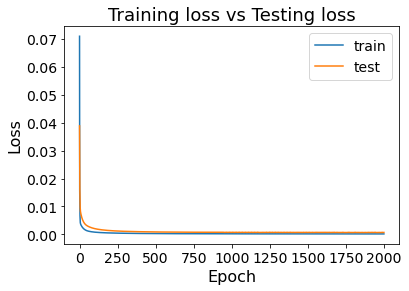

In [26]:
lr = 0.00001
EPOCHS = 2000
model_crnn_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('saved_model/rcnn.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model_crnn_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                           callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [27]:
from tensorflow.keras.models import load_model

model_load = load_model('saved_model/rcnn.h5')

In [28]:
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [29]:
# inv_y

In [30]:
# inv_yhat

In [31]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [32]:
error = inv_yhat - inv_y
error

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.089140,-0.052793,-0.014414,0.080070,-0.098472,-0.016746,0.036777,0.120411,-0.122015,-0.106160,...,-0.075773,0.196389,-0.048917,0.009969,-0.057569,0.212791,-0.095651,0.023422,-0.060702,0.208305
1,-0.047783,-0.056855,0.006091,0.126357,-0.090727,-0.118835,-0.023295,0.115992,-0.088630,-0.051149,...,-0.065464,0.162363,-0.093979,0.007112,-0.092841,0.111931,-0.064611,0.088779,-0.012007,0.144170
2,-0.025764,-0.110703,-0.024514,0.132618,-0.057686,-0.012100,0.019955,0.167526,-0.041136,0.053171,...,-0.062323,0.139637,0.019937,0.124448,-0.002803,0.176353,-0.084448,-0.035565,-0.008948,0.157611
3,-0.043693,-0.049769,0.015536,0.153971,-0.061701,-0.010613,0.012428,0.121120,-0.101148,-0.029449,...,-0.006737,0.163980,-0.086881,-0.039234,-0.039126,0.177212,-0.130899,-0.122568,-0.087349,0.042887
4,-0.038212,-0.006155,-0.025192,0.171689,-0.069152,-0.100698,-0.090935,0.186881,0.017554,0.107406,...,-0.043816,0.151077,-0.134044,-0.070508,-0.090786,0.068791,-0.232634,-0.126814,-0.158377,0.058478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19244,-0.040794,0.036235,-0.079095,0.231968,-0.046527,-0.016903,-0.144495,0.124685,-0.084170,0.035824,...,-0.028823,0.137587,-0.158723,-0.126295,-0.061592,0.228721,-0.096436,-0.103050,-0.102717,0.190518
19245,-0.090796,-0.075844,-0.149994,0.126926,-0.104566,-0.046318,-0.167023,0.091665,-0.010620,0.079110,...,-0.002484,0.158133,-0.083608,-0.068440,-0.099937,0.170237,-0.050757,-0.091871,-0.118084,0.230417
19246,-0.008668,-0.053414,-0.149486,0.111637,0.016079,0.044951,-0.012255,0.152538,-0.082456,0.011153,...,-0.104589,0.149316,-0.029470,-0.019565,-0.095452,0.193752,-0.074300,-0.054073,-0.156789,0.160491
19247,0.020287,-0.004887,-0.017690,0.133047,-0.104988,-0.023184,-0.098749,0.042258,-0.163400,0.027332,...,-0.071635,0.212860,-0.084385,-0.105442,-0.140518,0.158215,-0.074313,-0.053454,-0.157186,0.158096


In [33]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [34]:
len(error_19_20)

17544

In [35]:
inv_y.to_csv('./output/inv_y_rcnn.csv')
inv_yhat.to_csv('./output/inv_yhat_rcnn.csv')
error.to_csv('./output/error_rcnn.csv')

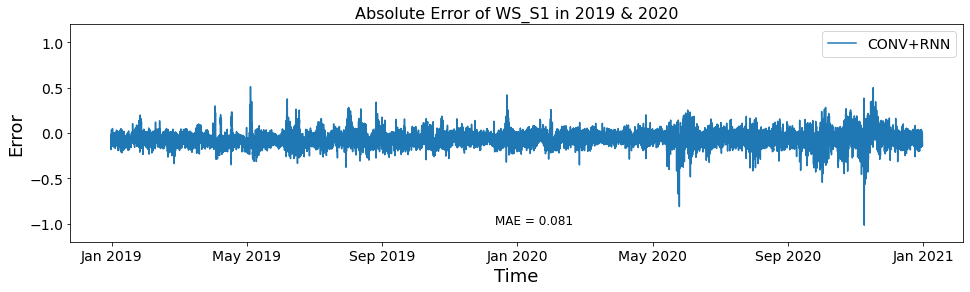

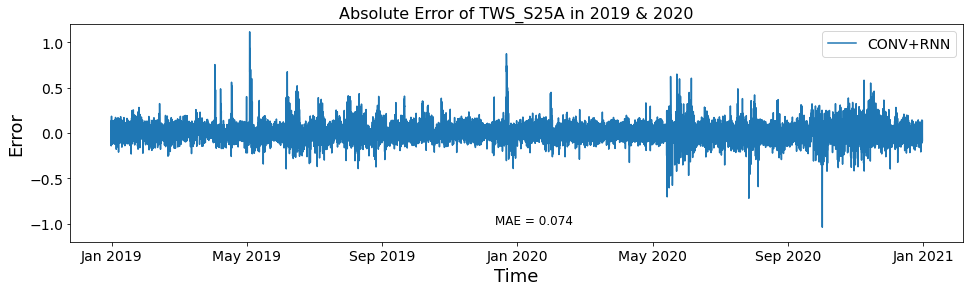

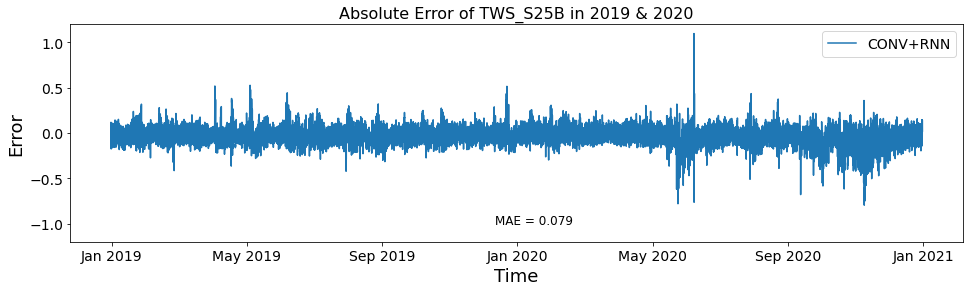

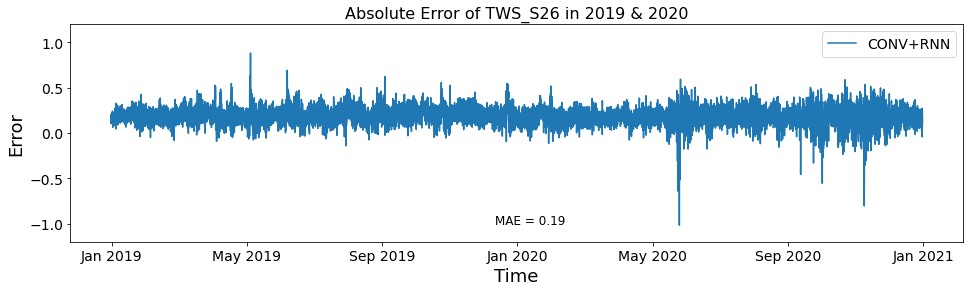

In [36]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
# locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'STORAGE', 'HWS_S25A', 'HWS_S25B']
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([68, 69, 70, 71]):
    plt.plot(error.iloc[-17544:, col], label='CONV+RNN')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.2, 1.2)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -1, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()